# Practical Problem 1

### Kyle Goyette ID: 
### Giancarlo Kerg ID: 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms

import numpy as np
import matplotlib.pyplot as plt

### Creation of Helper Functions

Below are an assortment of functions used during the assignment. Each is described below:

In [19]:

# An MLP class with rigid 2 hidden layer, 800 hidden units architecture, using RELu's as the non-linearities
# Parameters: l2_reg: if None, applies no l2 regularization, otherwise applies l2 weight decay
#             dropout: the probability of droping a connection in the second hidden layer, if unentered no dropout is used
#             loss_crit: 
class MLP_MNIST(nn.Module):
    
    def __init__(self,loss_crit):
        super(MLP_MNIST,self).__init__()
        self.fc1 = nn.Linear(28*28,800)
        self.fc2 = nn.Linear(800,800)
        self.fc3 = nn.Linear(800,10)
        
        
        self.insize = 28*28
        
        self.loss_crit = loss_crit
        
        params = list(self.parameters())
        for param in params:
            if len(param.shape)>1:
                nn.init.xavier_normal(param)
            else:
                nn.init.constant(param,0)

    def forward(self,x):
        a1 = self.fc1(x)
        h1 = nn.functional.relu(a1)
        
        a2 = self.fc2(h1)
        h2 = nn.functional.relu(a2)
        
        logits = self.fc3(h2)
        
        return logits
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices
    
    def calc_l2_norm(self):
        params = list(self.parameters())
        l2_norm = long(0)
        for param in params:
            if len(param.shape)>1:
                l2_norm +=  (torch.sum(torch.sum(torch.pow(param,2)))).data
            else:
                l2_norm += torch.sum(torch.pow(param,2)).data
        return torch.sqrt(l2_norm)
    
    def evaluate_model(self,loader):
        for batch_index,(inputs,targets) in enumerate(loader):
            x, targets = Variable(inputs.view([-1,self.insize])), Variable(targets)

            logits = self.forward(x)
            _, preds = self.prediction(logits)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
        accuracy = (correct/float(total))
        return accuracy
        

    def train_model(self, train_data,optimizer,batch_size, num_epochs,early_stopping=False, val_data = None, test_data = None, verbose=True ):
        #prepare optimizer
        train_loader, val_loader, test_loader = make_data_loaders(train_data,batch_size,val_data,test_data)
        
        bestValAcc = 0
        bestNetwork = 0
        train_accuracy = []
        val_accuracy = []
        test_accuracy = []
        epoch_loss=[]
        l2_norms=[] 
        for epoch in range(num_epochs):
            losses = []
            correct = 0
            total = 0
            val_correct = 0
            val_total = 0
            test_correct = 0
            test_total = 0

            for batch_index, (inputs,targets) in enumerate(train_loader):
                inputs = Variable(inputs.view([-1,self.insize]))
                targets = Variable(targets)
                optimizer.zero_grad()
                logits = self.forward(inputs)
                _,preds = self.prediction(logits)
                correct += preds.eq(targets.data).sum()
                total += targets.size(0)
                
                loss = self.loss_crit(logits,targets)
                
                loss.backward()
                optimizer.step()
                losses.append(loss.data[0])

                l2_norms.append(self.calc_l2_norm())
            epoch_loss.append(np.mean(losses))
            train_accuracy.append(correct/float(total))
            
            if (val_loader != None):
                val_acc = self.evaluate_model(val_loader)
                val_accuracy.append(val_acc)
                            
                if val_acc > bestValAcc:
                    bestNetwork = self
                    bestValAcc= val_acc
                
                if (early_stopping and val_acc < bestValAcc) :
                    return bestNetwork
        
                
            
            if (test_loader != None):
                test_acc = self.evaluate_model(test_loader)
                test_accuracy.append(test_acc)
            
            if (val_loader != None and test_loader != None and epoch%20 ==0  and verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
            elif (val_loader != None and test_loader == None and verbose == True and epoch%20==0):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
            elif (verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
        return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy,l2_norms)       



def make_data_loaders(train_data,batch_size,val_data=None,test_data=None):
    train_loader = torch.utils.data.DataLoader(train_data,batch_size,shuffle=True,num_workers=2)
    
    if (val_data != None): 
        val_loader = torch.utils.data.DataLoader(val_data,batch_size,shuffle=True,num_workers=2)
    else:
        val_loader = None
    if (test_data != None):
        test_loader = torch.utils.data.DataLoader(test_data,batch_size,shuffle=True,num_workers=2)
    else:
        test_loader = None
    return train_loader, val_loader, test_loader

def make_dataset(data,labels):
    data = torch.Tensor(data)
    labels = torch.IntTensor(labels)
    dataset = torch.utils.data.TensorDataset(data,labels)
    return dataset


        
            
        

## Preparing the Data

In [16]:

data_loc = '../data/mnist/mnist.pkl'
data = np.load(data_loc)
mnist_train_data = data[0][0]
mnist_train_labels = data[0][1]

mnist_train_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_train_data),torch.IntTensor(mnist_train_labels))

mnist_val_data = data[1][0]
mnist_val_labels = data[1][1]

mnist_val_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_val_data),torch.IntTensor(mnist_val_labels))


mnist_test_data = data[2][0]
mnist_test_labels = data[2][1]

train_dataset = make_dataset(mnist_train_data, mnist_train_labels)
val_dataset = make_dataset(mnist_val_data,mnist_val_labels)
test_dataset = make_dataset(mnist_test_data,mnist_test_labels)


In [17]:
print len(mnist_train_labels)

50000


## P1.a  Regularization : weight decay, early stopping, dropout, domain prior knowledge


In [18]:
lr = 0.02
batch_size=64
num_epochs=100
l2_reg = 0
batch_weight_decay = l2_reg/(float(len(mnist_train_labels))/float(batch_size))
print batch_weight_decay

No_reg_model = MLP_MNIST(loss_crit=nn.CrossEntropyLoss())
optimizer = torch.optim.SGD(No_reg_model.parameters(),lr=lr )
bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy,l2_norms = No_reg_model.train_model(train_dataset,optimizer,batch_size, num_epochs,early_stopping=False, val_data = None, test_data = None )

0.0
Epoch : 1 Loss : 0.591  Train Accuracy: 0.859
Epoch : 2 Loss : 0.287  Train Accuracy: 0.918
Epoch : 3 Loss : 0.236  Train Accuracy: 0.933
Epoch : 4 Loss : 0.202  Train Accuracy: 0.942
Epoch : 5 Loss : 0.176  Train Accuracy: 0.950
Epoch : 6 Loss : 0.156  Train Accuracy: 0.956
Epoch : 7 Loss : 0.139  Train Accuracy: 0.961
Epoch : 8 Loss : 0.125  Train Accuracy: 0.965
Epoch : 9 Loss : 0.113  Train Accuracy: 0.968
Epoch : 10 Loss : 0.103  Train Accuracy: 0.971
Epoch : 11 Loss : 0.095  Train Accuracy: 0.974
Epoch : 12 Loss : 0.087  Train Accuracy: 0.976
Epoch : 13 Loss : 0.080  Train Accuracy: 0.978
Epoch : 14 Loss : 0.074  Train Accuracy: 0.980
Epoch : 15 Loss : 0.069  Train Accuracy: 0.981
Epoch : 16 Loss : 0.064  Train Accuracy: 0.983
Epoch : 17 Loss : 0.059  Train Accuracy: 0.984
Epoch : 18 Loss : 0.055  Train Accuracy: 0.985
Epoch : 19 Loss : 0.051  Train Accuracy: 0.986
Epoch : 20 Loss : 0.048  Train Accuracy: 0.988
Epoch : 21 Loss : 0.044  Train Accuracy: 0.989
Epoch : 22 Loss : 

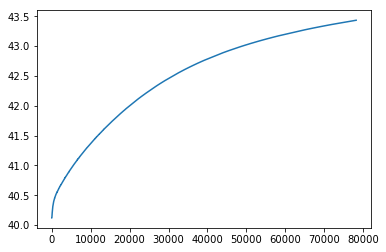

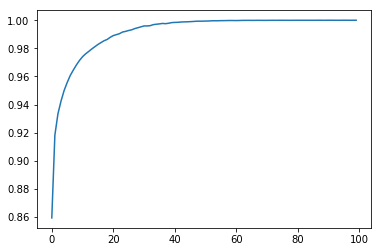

In [20]:
plt.plot(l2_norms)
plt.show()

plt.plot(train_accuracy)
plt.show()

In [22]:
lr = 0.02
batch_size=64
num_epochs=100
l2_reg = 2.5
batch_weight_decay = l2_reg/(float(len(mnist_train_labels))/float(batch_size))
print batch_weight_decay

reg_model = MLP_MNIST(loss_crit=nn.CrossEntropyLoss())
optimizer = torch.optim.SGD(reg_model.parameters(),lr=lr,weight_decay = batch_weight_decay )
bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy,l2_norms = reg_model.train_model(train_dataset,optimizer,batch_size, num_epochs,early_stopping=False, val_data = None, test_data = None )

0.0032
Epoch : 1 Loss : 0.616  Train Accuracy: 0.849
Epoch : 2 Loss : 0.301  Train Accuracy: 0.916
Epoch : 3 Loss : 0.255  Train Accuracy: 0.930
Epoch : 4 Loss : 0.226  Train Accuracy: 0.938
Epoch : 5 Loss : 0.205  Train Accuracy: 0.944
Epoch : 6 Loss : 0.189  Train Accuracy: 0.948
Epoch : 7 Loss : 0.175  Train Accuracy: 0.953
Epoch : 8 Loss : 0.164  Train Accuracy: 0.955
Epoch : 9 Loss : 0.156  Train Accuracy: 0.958
Epoch : 10 Loss : 0.149  Train Accuracy: 0.960
Epoch : 11 Loss : 0.142  Train Accuracy: 0.963
Epoch : 12 Loss : 0.136  Train Accuracy: 0.964
Epoch : 13 Loss : 0.132  Train Accuracy: 0.966
Epoch : 14 Loss : 0.127  Train Accuracy: 0.967
Epoch : 15 Loss : 0.124  Train Accuracy: 0.969
Epoch : 16 Loss : 0.121  Train Accuracy: 0.970
Epoch : 17 Loss : 0.118  Train Accuracy: 0.971
Epoch : 18 Loss : 0.115  Train Accuracy: 0.971
Epoch : 19 Loss : 0.113  Train Accuracy: 0.972
Epoch : 20 Loss : 0.111  Train Accuracy: 0.973
Epoch : 21 Loss : 0.109  Train Accuracy: 0.973
Epoch : 22 Loss

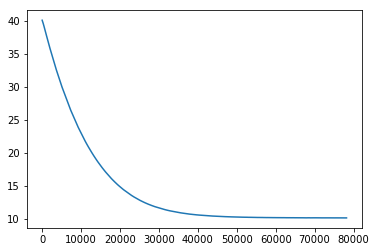

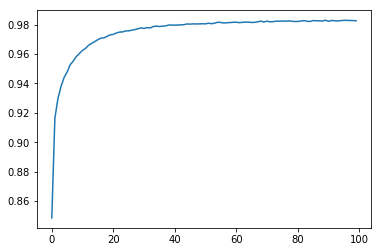

In [23]:
plt.plot(l2_norms)
plt.show()

plt.plot(train_accuracy)
plt.show()

## 1.b Dropout

In [45]:
class Dropout_MLP(nn.Module):
    def __init__(self, dropout):
        super(Dropout_MLP,self).__init__()
        self.fc1 = nn.Linear(28*28,800)
        self.fc2 = nn.Linear(800,800)
        self.dropout = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(800,10)
        
        self.insize = 28*28
        self.l2_reg = l2_reg
        
        self.loss_crit = nn.NLLLoss()
        
        params = list(self.parameters())
        for param in params:
            if len(param.shape)>1:
                nn.init.xavier_normal(param)
            else:
                nn.init.constant(param,0)
                
                
    def forward(self,x):
        lsm = nn.LogSoftmax(1)
        a1 = self.fc1(x)
        h1 = nn.functional.relu(a1)
        
        a2 = self.fc2(h1)
        d2 = self.dropout(a2)
        h2 = nn.functional.relu(d2)
        
        logits = self.fc3(h2)
        probs = lsm(logits)
        
        return probs
    def predictions(self,x,eval_type, N=1):
        lsm = nn.Softmax(1)
        if eval_type == 'average_pre':
            averages = torch.zeros(x.shape[0],10)
        elif eval_type == 'average_preds':
            averages = torch.zeros(x.shape[0])
        for i in range(N):

            a1 = self.fc1(x)
            h1 = nn.functional.relu(a1)
        
            a2 = self.fc2(h1)
            if eval_type == 'half':
                torch.manual_seed(1000)
                d2 = self.dropout(a2)
            else:
                d2 = self.dropout(a2)
            h2 = nn.functional.relu(d2)
            if (eval_type == 'half'):
                h2 = h2*0.5
                logits = self.fc3(h2)
                probs = lsm(logits)
                _,preds = torch.max(probs.data,1)
                return preds
            elif (eval_type == 'average_pre'):
                logits = self.fc3(h2)
                averages += logits.data
            elif (eval_type == 'average_preds'):
                logits = self.fc3(h2)
                probs = lsm(logits)
                _,preds = torch.max(probs.data,1)
                preds = preds.type(torch.FloatTensor)
                averages += preds
            
        if (eval_type == 'average_pre'):
            averages = torch.div(averages,N)
            averages = Variable(averages)
            probs = lsm(averages)
            _, preds = torch.max(probs.data,1)
            return preds

        if (eval_type == 'average_preds'):
            preds = torch.div(averages,N)
            preds = torch.round(preds)
            preds = preds.type(torch.LongTensor)
            return preds

    
    def evaluate_model(self,loader,eval_type,N=1):
        correct=0
        total=0
        for batch_index,(inputs,targets) in enumerate(loader):
            x, targets = Variable(inputs.view([-1,self.insize])), Variable(targets)

            preds = self.predictions(x,eval_type,N)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
        accuracy = (correct/float(total))
        return accuracy
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices
    
    
    def train_model(self, train_data,optimizer,batch_size, num_epochs,early_stopping=False, val_data = None, test_data = None, verbose=True ):
        #prepare optimizer
        train_loader, val_loader, test_loader = make_data_loaders(train_data,batch_size,val_data,test_data)
        
        bestValAcc = 0
        bestNetwork = 0
        train_accuracy = []
        val_accuracy = []
        test_accuracy = []
        epoch_loss=[]
        for epoch in range(num_epochs):
            losses = []
            correct = 0
            total = 0
            val_correct = 0
            val_total = 0
            test_correct = 0
            test_total = 0

            for batch_index, (inputs,targets) in enumerate(train_loader):
                inputs = Variable(inputs.view([-1,self.insize]))
                targets = Variable(targets)
                optimizer.zero_grad()
                logits = self.forward(inputs)
                _,preds = self.prediction(logits)
                correct += preds.eq(targets.data).sum()
                total += targets.size(0)
                
                loss = self.loss_crit(logits,targets)
                
                loss.backward()
                optimizer.step()
                losses.append(loss.data[0])
            epoch_loss.append(np.mean(losses))
            train_accuracy.append(correct/float(total))
            
            if (val_loader != None):
                val_acc = evaluate_model(val_loader)
                val_accuracy.append(val_acc)
                            
                if val_acc > bestValAcc:
                    bestNetwork = self
                    bestValAcc= val_acc
                
                if (early_stopping and val_acc < bestValAcc) :
                    return bestNetwork
        
                
            
            if (test_loader != None):
                test_acc = evaluate_model(test_loader)
                test_accuracy.append(test_acc)
            
            if (val_loader != None and test_loader != None and verbose == True and epoch%10==0):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
            elif (val_loader != None and test_loader == None and verbose == True and epoch%20==0):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
            elif (verbose == True and epoch%10==0):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
        return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy)       


In [46]:
lr = 0.02
batch_size=64
num_epochs=100

DropoutModel = Dropout_MLP(0.5)
optimizer = torch.optim.SGD(DropoutModel.parameters(),lr=lr )
results = DropoutModel.train_model(train_dataset,optimizer,batch_size, num_epochs)

Epoch : 1 Loss : 0.677  Train Accuracy: 0.813
Epoch : 11 Loss : 0.116  Train Accuracy: 0.966
Epoch : 21 Loss : 0.064  Train Accuracy: 0.981
Epoch : 31 Loss : 0.041  Train Accuracy: 0.989
Epoch : 41 Loss : 0.027  Train Accuracy: 0.993
Epoch : 51 Loss : 0.019  Train Accuracy: 0.995
Epoch : 61 Loss : 0.013  Train Accuracy: 0.997
Epoch : 71 Loss : 0.010  Train Accuracy: 0.998
Epoch : 81 Loss : 0.007  Train Accuracy: 0.999
Epoch : 91 Loss : 0.006  Train Accuracy: 0.999


In [47]:
Ns = [10*i for i in range(1,10)]
test_loader,_,_ = make_data_loaders(test_dataset,64,val_dataset,test_dataset)
half_acc = [0]*len(Ns)
pre_acc = [0]*len(Ns)
pred_acc = [0]*len(Ns)
for i,N in enumerate(Ns):
    half_acc[i] = DropoutModel.evaluate_model(test_loader,'half',N)
    pre_acc[i] = DropoutModel.evaluate_model(test_loader,'average_pre',N)
    pred_acc[i] = DropoutModel.evaluate_model(test_loader,'average_preds',N)

## 1.b.i-iii Accuracy Plots for different Dropout evaluation procedures

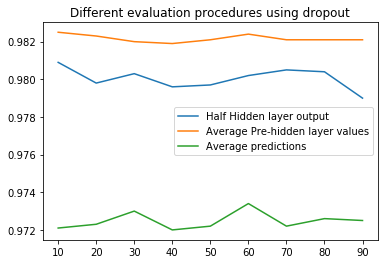

In [48]:
plt.plot(Ns,half_acc, label='Half Hidden layer output')
plt.plot(Ns,pre_acc, label='Average Pre-hidden layer values')
plt.plot(Ns,pred_acc,label='Average predictions')
plt.legend()
plt.title('Different evaluation procedures using dropout')
plt.show()

The different types of ensemble procedures shown here are:

### 1.c Convolutional Networks

In [389]:
class ConvNet(nn.Module):
    def __init__(self,batch_norm=False):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(3,3), padding=1)
        if (batch_norm):
            self.bnorm1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(p=0.5)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=2)

        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3), padding=1)
        if (batch_norm):
            self.bnorm2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(p=0.5)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2),stride=2)

        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3), padding=1)
        if (batch_norm):
            self.bnorm3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(p=0.5)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2),stride=2)

        self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3), padding=1)
        if (batch_norm):
            self.bnorm4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=(2,2),stride=2)

        self.fc = nn.Linear(128,10)
        self.batch_norm=batch_norm
        #self.indims = [-1,1,28,28]
        
        self.loss_crit = nn.CrossEntropyLoss()
        
    def forward(self,x):
        a1 = self.conv1(x)
        d1 = self.dropout1(a1)
        if (self.batch_norm):
            d1 = self.bnorm1(d1)
        d1 = nn.functional.relu(d1)
        p1 = self.pool1(d1)
        
        a2 = self.conv2(p1)
        d2 = self.dropout2(a2)
        if (self.batch_norm):
            d2 = self.bnorm1(d2)
        d2 = nn.functional.relu(d2)
        p2 = self.pool2(d2)
        
        a3 = self.conv3(p2)
        d3 = self.dropout3(a3)
        if (self.batch_norm):
            d3 = self.bnorm1(d3)
        d3 = nn.functional.relu(d3)
        p3 = self.pool3(d3)
        
        a4 = self.conv4(p3)
        d4=self.dropout4(a4)
        if (self.batch_norm):
            d4 = self.bnorm1(d4)
        d4 = nn.functional.relu(d4)
        p4 = self.pool4(d4)
        
        logits = self.fc(p4.squeeze())
        
        return logits
    
    def prediction(self,logits):
        
        _, preds = torch.max(logits.data,1)
        
        return preds
    
    def evaluate_model(self,loader):
        correct = 0
        total = 0
        for batch_index,(inputs,targets) in enumerate(loader):
            x, targets = Variable(inputs.view([-1,1,28,28])), Variable(targets)

            logits = self.forward(x)
            preds = self.prediction(logits)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
        accuracy = (correct/float(total))
        return accuracy
    
    def train_model(self, train_data, optimizer,batch_size, num_epochs,early_stopping=False, val_data = None, test_data = None, verbose=True ):
        #prepare optimizer
        train_loader, val_loader, test_loader = make_data_loaders(train_data,batch_size,val_data,test_data)
        
        bestValAcc = 0
        bestNetwork = 0
        train_accuracy = []
        val_accuracy = []
        test_accuracy = []
        epoch_loss=[]
        for epoch in range(num_epochs):
            losses = []
            correct = 0
            total = 0
            val_correct = 0
            val_total = 0
            test_correct = 0
            test_total = 0

            for batch_index, (inputs,targets) in enumerate(train_loader):
                inputs = Variable(inputs.view([-1,1,28,28]))
                targets = Variable(targets)
                optimizer.zero_grad()
                logits = self.forward(inputs)
                preds = self.prediction(logits)
                correct += preds.eq(targets.data).sum()
                total += targets.size(0)
                
                loss = self.loss_crit(logits,targets)
                
                loss.backward()
                optimizer.step()
                losses.append(loss.data[0])
            epoch_loss.append(np.mean(losses))
            train_accuracy.append(correct/float(total))
            
            if (val_loader != None):
                val_acc = self.evaluate_model(val_loader)
                val_accuracy.append(val_acc)
                            
                if val_acc > bestValAcc:
                    bestNetwork = self
                    bestValAcc= val_acc
                
                if (early_stopping and val_acc < bestValAcc) :
                    return bestNetwork
        
                
            
            if (test_loader != None):
                test_acc = self.evaluate_model(test_loader)
                test_accuracy.append(test_acc)
            
            if (val_loader != None and test_loader != None and verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
            elif (val_loader != None and test_loader == None and verbose == True and epoch%20==0):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
            elif (verbose == True and epoch%20==0):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
        return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy,l2_norms)

In [390]:
print mnist_train_data.shape

(50000, 784)


In [391]:
mnist_train_data_r = mnist_train_data.reshape((mnist_train_data.shape[0],28,28))
mnist_val_data_r = mnist_val_data.reshape((mnist_val_data.shape[0],28,28))
mnist_test_data_r = mnist_test_data.reshape((mnist_test_data.shape[0],28,28))

mnist_ctrain_dataset = make_dataset(mnist_train_data_r,mnist_train_labels)
mnist_cval_dataset = make_dataset(mnist_val_data_r, mnist_val_labels)
mnist_ctest_dataset = make_dataset(mnist_test_data_r, mnist_test_labels)


In [392]:
lr = 0.00001
batch_size = 64
num_epochs = 10
loss_crit = nn.CrossEntropyLoss()
MNIST_ConvNet = ConvNet()
optimizer = torch.optim.SGD(MNIST_ConvNet.parameters(),lr=lr)
train_results = MNIST_ConvNet.train_model(mnist_ctrain_dataset,optimizer, batch_size,num_epochs, val_data = mnist_cval_dataset, test_data = mnist_ctest_dataset)

Epoch : 1 Loss : 2.294  Train Accuracy: 0.133 Validation Accuracy: 0.155 Test Accuracy: 0.145
Epoch : 2 Loss : 2.032  Train Accuracy: 0.289 Validation Accuracy: 0.480 Test Accuracy: 0.461
Epoch : 3 Loss : 1.118  Train Accuracy: 0.624 Validation Accuracy: 0.727 Test Accuracy: 0.733
Epoch : 4 Loss : 0.704  Train Accuracy: 0.773 Validation Accuracy: 0.827 Test Accuracy: 0.818
Epoch : 5 Loss : 0.521  Train Accuracy: 0.836 Validation Accuracy: 0.863 Test Accuracy: 0.860
Epoch : 6 Loss : 0.457  Train Accuracy: 0.857 Validation Accuracy: 0.880 Test Accuracy: 0.885
Epoch : 7 Loss : 0.435  Train Accuracy: 0.870 Validation Accuracy: 0.882 Test Accuracy: 0.889
Epoch : 8 Loss : 0.401  Train Accuracy: 0.881 Validation Accuracy: 0.885 Test Accuracy: 0.885
Epoch : 9 Loss : 0.418  Train Accuracy: 0.881 Validation Accuracy: 0.880 Test Accuracy: 0.883
Epoch : 10 Loss : 0.405  Train Accuracy: 0.881 Validation Accuracy: 0.893 Test Accuracy: 0.895


In [393]:
lr = 0.001
batch_size = 64
num_epochs = 10
loss_crit = nn.CrossEntropyLoss()
BN_MNIST_ConvNet = ConvNet(batch_norm=True)
optimizer = torch.optim.SGD(BN_MNIST_ConvNet.parameters(),lr=lr)
train_results = MNIST_ConvNet.train_model(mnist_ctrain_dataset,optimizer, batch_size,num_epochs, val_data = mnist_cval_dataset, test_data = mnist_ctest_dataset)

Epoch : 1 Loss : 0.408  Train Accuracy: 0.884 Validation Accuracy: 0.892 Test Accuracy: 0.894
Epoch : 2 Loss : 0.402  Train Accuracy: 0.886 Validation Accuracy: 0.895 Test Accuracy: 0.891
Epoch : 3 Loss : 0.413  Train Accuracy: 0.885 Validation Accuracy: 0.899 Test Accuracy: 0.893
Epoch : 4 Loss : 0.404  Train Accuracy: 0.886 Validation Accuracy: 0.897 Test Accuracy: 0.894
Epoch : 5 Loss : 0.405  Train Accuracy: 0.886 Validation Accuracy: 0.896 Test Accuracy: 0.894
Epoch : 6 Loss : 0.400  Train Accuracy: 0.886 Validation Accuracy: 0.894 Test Accuracy: 0.896
Epoch : 7 Loss : 0.398  Train Accuracy: 0.887 Validation Accuracy: 0.894 Test Accuracy: 0.899
Epoch : 8 Loss : 0.415  Train Accuracy: 0.886 Validation Accuracy: 0.902 Test Accuracy: 0.897
Epoch : 9 Loss : 0.397  Train Accuracy: 0.886 Validation Accuracy: 0.895 Test Accuracy: 0.894
Epoch : 10 Loss : 0.402  Train Accuracy: 0.887 Validation Accuracy: 0.899 Test Accuracy: 0.895
